In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install chart-studio
!pip install cufflinks
!pip install imblearn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline
from chart_studio import plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
import cufflinks as cf
import warnings
warnings.filterwarnings("ignore")
import gc
gc.enable()
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

In [5]:
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID', nrows = 50000)
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID', nrows = 50000)

In [6]:
pd.set_option('display.max_columns', 400)

In [7]:
train_identity

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   
...              ...       ...    ...    ...    ...    ...    ...    ...   
3100492         -5.0  113104.0    NaN    NaN    0.0    0.0    NaN    NaN   
3100494         -5.0   56308.0    NaN    NaN    0.0    0.0    NaN    NaN   
3100495         -5.0  363555.0    0.0    0.0    0.0    0.0    NaN    NaN   
3100496         -5.0   77730.0    NaN    NaN   11.0  -31.0    NaN    NaN   
3100497         -5.0  138174.0    NaN    NaN    0.0    0.0    NaN    NaN   

               id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  \
TransactionID                                                                 
2987004          NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound   
2987008          NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound   
2987010          0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found   
2987011          NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound   
2987016          0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found   
...              ...    ...    ...       ...    ...    ...    ...       ...   
3100492          NaN    NaN  100.0     Found   52.0 -300.0    New  NotFound   
3100494          NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound   
3100495          0.0    0.0  100.0  NotFound   52.0 -360.0  Found     Found   
3100496          NaN    NaN  100.0  NotFound   49.0 -360.0    New  NotFound   
3100497          NaN    NaN  100.0  NotFound   49.0 -480.0    New  NotFound   

               id_17  id_18  id_19  id_20  id_21  id_22 id_23  id_24  id_25  \
TransactionID                                                                 
2987004        166.0    NaN  542.0  144.0    NaN    NaN   NaN    NaN    NaN   
2987008        166.0    NaN  621.0  500.0    NaN    NaN   NaN    NaN    NaN   
2987010        121.0    NaN  410.0  142.0    NaN    NaN   NaN    NaN    NaN   
2987011        225.0    NaN  176.0  507.0    NaN    NaN   NaN    NaN    NaN   
2987016        166.0   15.0  529.0  575.0    NaN    NaN   NaN    NaN    NaN   
...              ...    ...    ...    ...    ...    ...   ...    ...    ...   
3100492        166.0   13.0  100.0  368.0    NaN    NaN   NaN    NaN    NaN   
3100494        166.0   15.0  193.0  391.0    NaN    NaN   NaN    NaN    NaN   
3100495        166.0    NaN  542.0  333.0    NaN    NaN   NaN    NaN    NaN   
3100496        166.0   13.0  122.0  214.0    NaN    NaN   NaN    NaN    NaN   
3100497        166.0    NaN  454.0  222.0    NaN    NaN   NaN    NaN    NaN   

               id_26 id_27  id_28     id_29             id_30  \
TransactionID                                                   
2987004          NaN   NaN    New  NotFound       Android 7.0   
2987008          NaN   NaN    New  NotFound        iOS 11.1.2   
2987010          NaN   NaN  Found     Found               NaN   
2987011          NaN   NaN    New  NotFound               NaN   
2987016          NaN   NaN  Found     Found  Mac OS X 10_11_6   
...              ...   ...    ...       ...               ...   
3100492          NaN   NaN    New  NotFound        Windows 10   
3100494          NaN   NaN    New  NotFound  Mac OS X 10_11_6   
3100495          NaN   NaN  Found     Found        Windows 10   
3100496          NaN   NaN    New  NotFound        iOS 11.2.1   
3100497          NaN   NaN    New  NotFound        iOS 10.3.3   

                             id_31  id_32      id_33           id_34 id_35  \
TransactionID                                 

In [8]:
columns = ["id_30", "id_31", "id_32", "id_33", "id_35", "id_36", "id_37", "id_38", "DeviceType"]

In [9]:
train_identity = train_identity[columns].copy()

In [10]:
train_identity

id_30                id_31  id_32      id_33 id_35  \
TransactionID                                                                  
2987004             Android 7.0  samsung browser 6.2   32.0  2220x1080     T   
2987008              iOS 11.1.2   mobile safari 11.0   32.0   1334x750     T   
2987010                     NaN          chrome 62.0    NaN        NaN     F   
2987011                     NaN          chrome 62.0    NaN        NaN     F   
2987016        Mac OS X 10_11_6          chrome 62.0   24.0   1280x800     T   
...                         ...                  ...    ...        ...   ...   
3100492              Windows 10            edge 16.0   24.0  2736x1824     T   
3100494        Mac OS X 10_11_6          chrome 63.0   24.0   1440x900     T   
3100495              Windows 10            edge 15.0   24.0  1920x1080     T   
3100496              iOS 11.2.1   mobile safari 11.0   32.0   1334x750     T   
3100497              iOS 10.3.3   mobile safari 10.0   32.0   1334x750     T   

              id_36 id_37 id_38 DeviceType  
TransactionID                               
2987004           F     T     T     mobile  
2987008           F     F     T     mobile  
2987010           F     T     T    desktop  
2987011           F     T     T    desktop  
2987016           F     T     T    desktop  
...             ...   ...   ...        ...  
3100492           F     T     T    desktop  
3100494           F     T     F    desktop  
3100495           F     T     T    desktop  
3100496           F     F     F     mobile  
3100497           F     F     F     mobile  

[50000 rows x 9 columns]

In [11]:
train_transaction

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400          68.500         W  13926    NaN   
2987001              0          86401          29.000         W   2755  404.0   
2987002              0          86469          59.000         W   4663  490.0   
2987003              0          86499          50.000         W  18132  567.0   
2987004              0          86506          50.000         H   4497  514.0   
...                ...            ...             ...       ...    ...    ...   
3036995              0        1189287         117.000         W  17188  321.0   
3036996              0        1189295         200.000         R  15063  514.0   
3036997              0        1189302         648.420         W   1333  170.0   
3036998              0        1189311          21.221         C  12722  555.0   
3036999              0        1189336         125.000         R   2616  327.0   

               card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
TransactionID                                                                 
2987000        150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
2987001        150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2987002        150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
2987003        150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
2987004        150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   
...              ...         ...    ...     ...    ...    ...    ...    ...   
3036995        150.0        visa  226.0   debit  299.0   87.0    NaN    NaN   
3036996        150.0        visa  226.0  credit  330.0   87.0    NaN    NaN   
3036997        150.0        visa  195.0  credit  231.0   87.0    NaN    NaN   
3036998        147.0  mastercard  166.0   debit  214.0   26.0    NaN  284.0   
3036999        150.0    discover  102.0  credit  123.0   87.0    NaN    NaN   

              P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
TransactionID                                                                  
2987000                 NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987001           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987002         outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2987003           yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
2987004           gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
...                     ...           ...  ...  ...  ...  ...  ...  ...  ...   
3036995                 NaN           NaN  4.0  3.0  0.0  0.0  3.0  4.0  0.0   
3036996         hotmail.com   hotmail.com  1.0  1.0  0.0  1.0  0.0  1.0  0.0   
3036997         hotmail.com           NaN  1.0  1.0  0.0  0.0  1.0  1.0  0.0   
3036998         hotmail.com   hotmail.com  1.0  8.0  0.0  1.0  0.0  1.0  1.0   
3036999           gmail.com     gmail.com  1.0  1.0  0.0  1.0  0.0  1.0  0.0   

                C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4  \
TransactionID                                                                 
2987000        0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN   
2987001        0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987002        0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
2987003        0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0   
2987004        1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   
...            ...  ...  ...  ...  ...   ...  ...    ...    ...   ...   ...   
3036995        0.0  3.0  0.0  4.0  0.0  76.0  2.0  409.0  409.0   2.0   NaN   
3036996        1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   
3036997        0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   
3036998        1.0  0.0

In [12]:
columns1 = ["ProductCD", "card1", "card2", "card3", "card5", "addr1", "addr2", "dist1", "dist2", "addr1", "addr2", "dist1",	"dist2", "M4", "P_emaildomain", "R_emaildomain"]

In [13]:
train_transaction = train_transaction.drop(columns1, axis = 1)

In [14]:
train_transaction

isFraud  TransactionDT  TransactionAmt       card4   card6  \
TransactionID                                                               
2987000              0          86400          68.500    discover  credit   
2987001              0          86401          29.000  mastercard  credit   
2987002              0          86469          59.000        visa   debit   
2987003              0          86499          50.000  mastercard   debit   
2987004              0          86506          50.000  mastercard  credit   
...                ...            ...             ...         ...     ...   
3036995              0        1189287         117.000        visa   debit   
3036996              0        1189295         200.000        visa  credit   
3036997              0        1189302         648.420        visa  credit   
3036998              0        1189311          21.221  mastercard   debit   
3036999              0        1189336         125.000    discover  credit   

                C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
TransactionID                                                               
2987000        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
2987001        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2987002        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987003        2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987004        1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3036995        4.0  3.0  0.0  0.0  3.0  4.0  0.0  0.0  3.0  0.0  4.0  0.0   
3036996        1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
3036997        1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
3036998        1.0  8.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  3.0  1.0  1.0   
3036999        1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

                C13  C14     D1     D2    D3    D4   D5    D6   D7     D8  \
TransactionID                                                               
2987000         1.0  1.0   14.0    NaN  13.0   NaN  NaN   NaN  NaN    NaN   
2987001         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
2987002         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
2987003        25.0  1.0  112.0  112.0   0.0  94.0  0.0   NaN  NaN    NaN   
2987004         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   
...             ...  ...    ...    ...   ...   ...  ...   ...  ...    ...   
3036995        76.0  2.0  409.0  409.0   2.0   NaN  NaN   NaN  NaN    NaN   
3036996         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   
3036997         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
3036998         3.0  1.0   14.0   14.0   0.0  14.0  0.0  14.0  0.0  14.75   
3036999         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   

                 D9    D10    D11   D12   D13  D14    D15   M1   M2   M3   M5  \
TransactionID                                                                   
2987000         NaN   13.0   13.0   NaN   NaN  NaN    0.0    T    T    T    F   
2987001         NaN    0.0    NaN   NaN   NaN  NaN    0.0  NaN  NaN  NaN    T   
2987002         NaN    0.0  315.0   NaN   NaN  NaN  315.0    T    T    T    F   
2987003         NaN   84.0    NaN   NaN   NaN  NaN  111.0  NaN  NaN  NaN    T   
2987004         NaN    NaN    NaN   NaN   NaN  NaN    NaN  NaN  NaN  NaN  NaN   
...             ...    ...    ...   ...   ...  ...    ...  ...  ...  ...  ...   
3036995         NaN  386.0    NaN   NaN   NaN  NaN  386.0  NaN  NaN  NaN    T   
3036996         NaN    NaN    NaN   NaN   NaN  NaN    NaN  NaN  NaN  NaN  NaN   
3036997         NaN    0.0    NaN   NaN   NaN  NaN    0.0  NaN  NaN  NaN  NaN   
3036998        0.75    0.0    NaN  14.0  14.0  0.0   14.0  NaN  NaN  NaN  NaN   
3036999         NaN    NaN    NaN   N

In [15]:
x = train_transaction['isFraud'].value_counts().index
y = train_transaction['isFraud'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - isFraud",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

In [16]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud           0
TransactionDT     0
TransactionAmt    0
card4             6
card6             3
C1                0
C2                0
C3                0
C4                0
C5                0
dtype: int64
% of missing data =  42.450136482939634


In [17]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_30         13045
id_31          1387
id_32         13043
id_33         15771
id_35          1218
id_36          1218
id_37          1218
id_38          1218
DeviceType     1337
dtype: int64
% of missing data =  10.99


In [18]:
del missing_values_count, total_cells, total_missing

In [19]:
del x, y

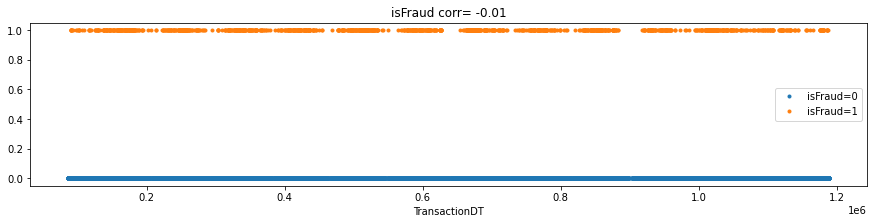

In [20]:
i = 'isFraud'
cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

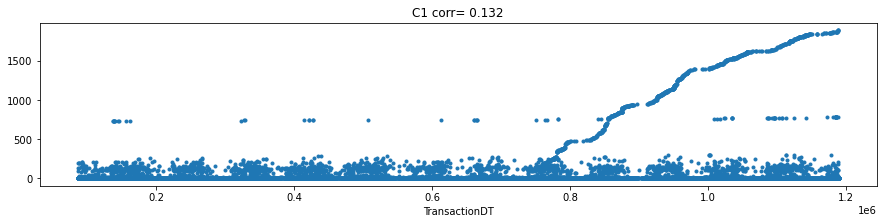

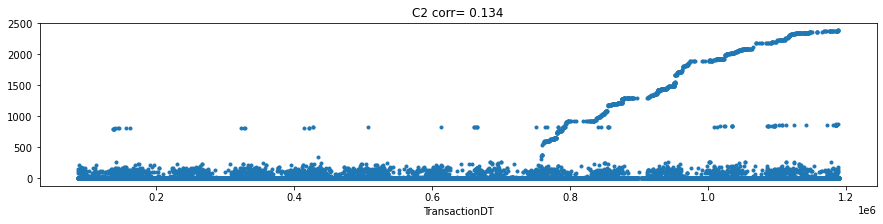

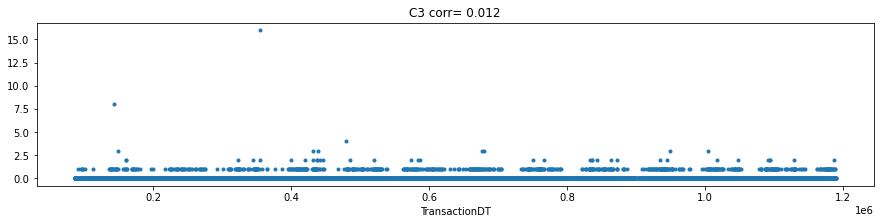

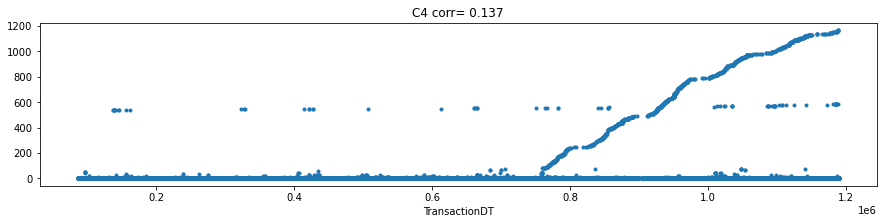

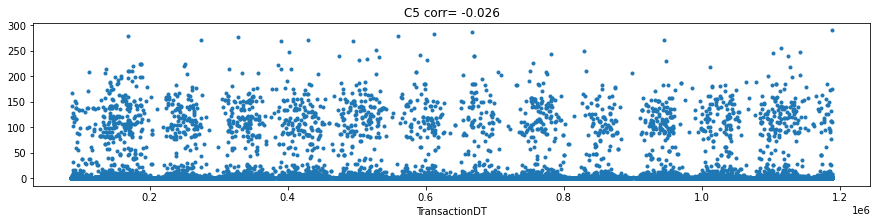

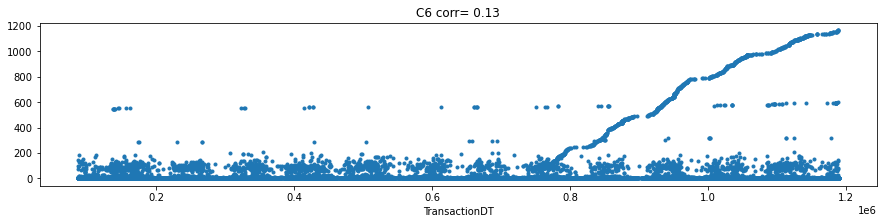

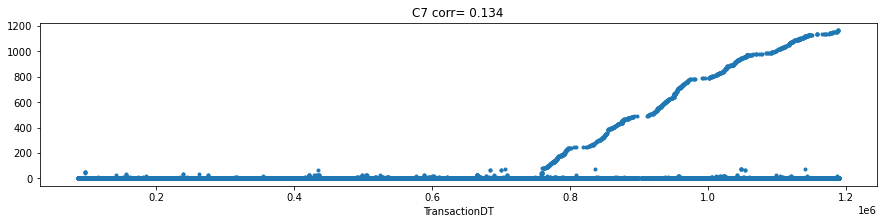

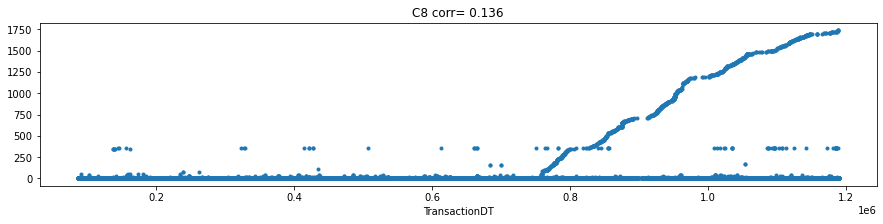

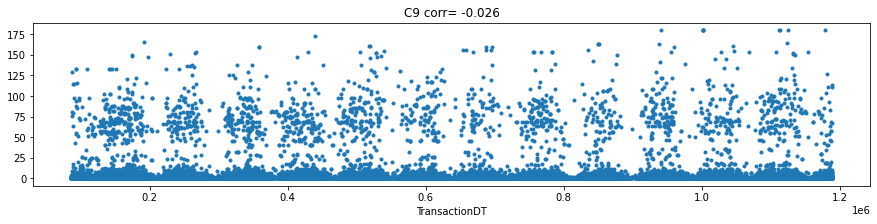

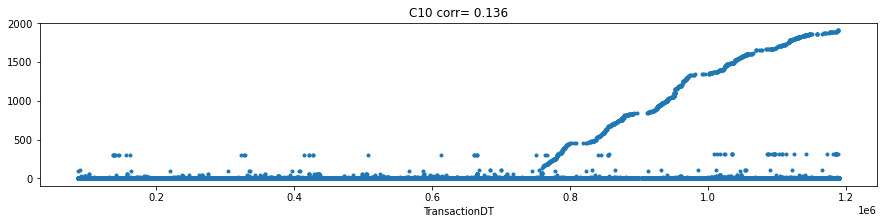

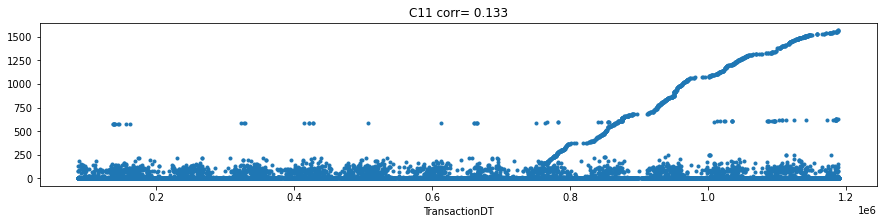

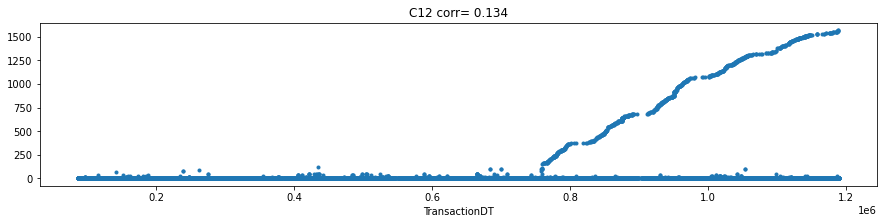

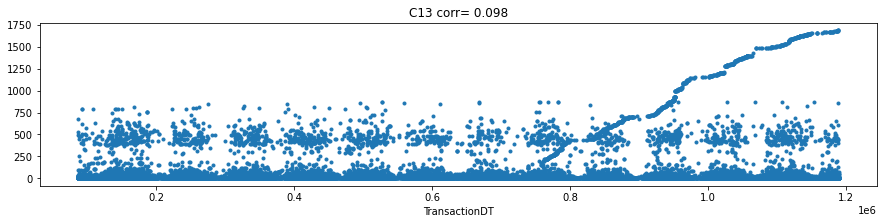

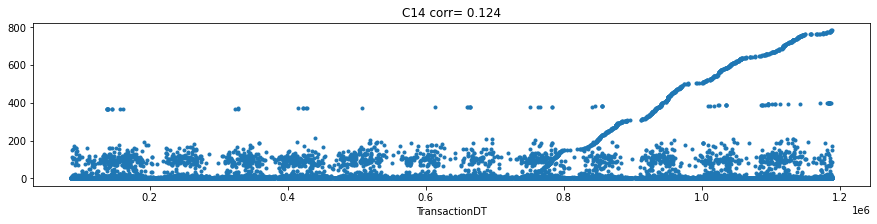

In [21]:
c_features = list(train_transaction.columns[5:19])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

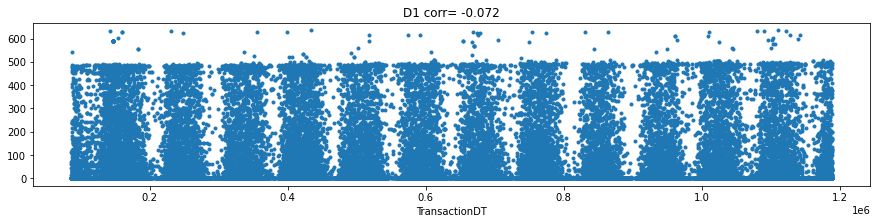

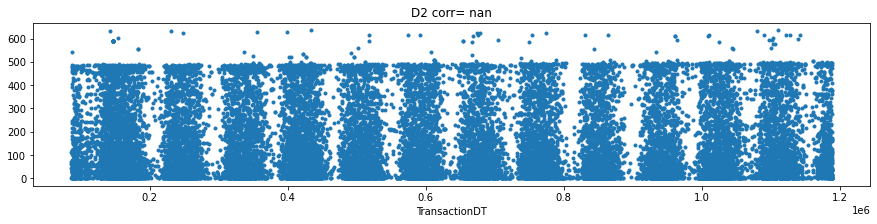

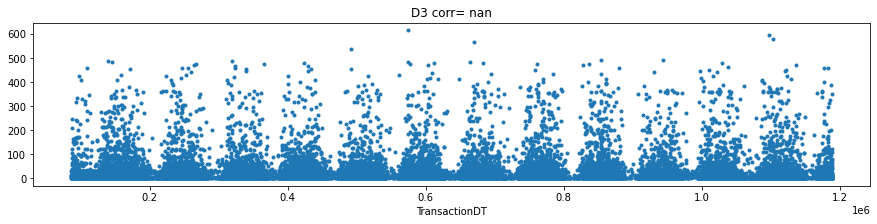

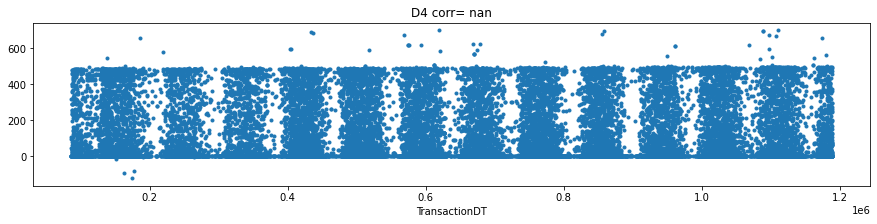

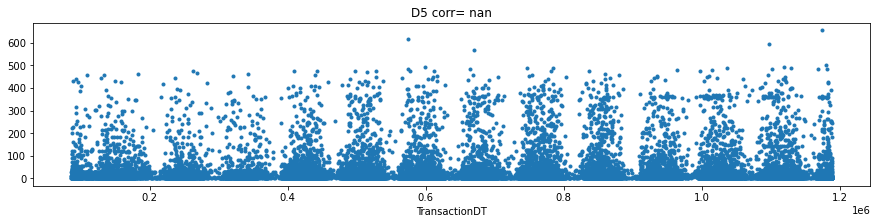

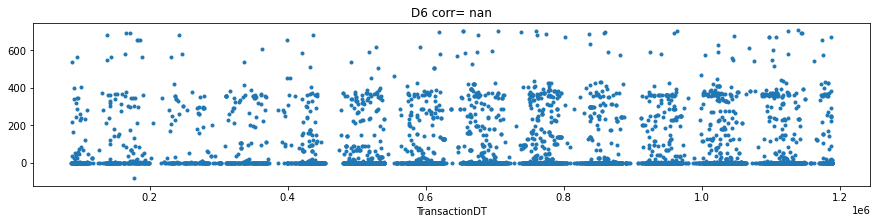

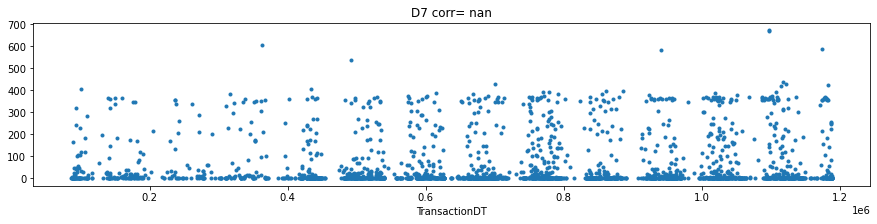

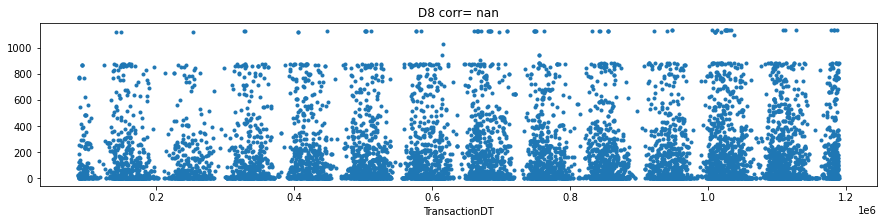

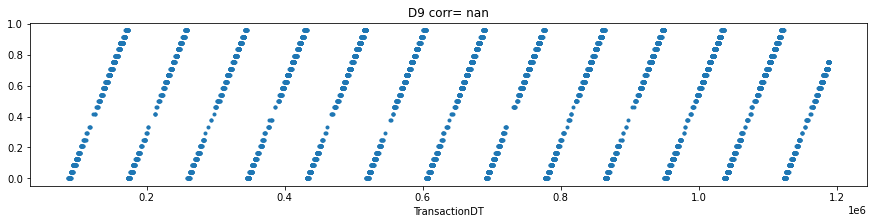

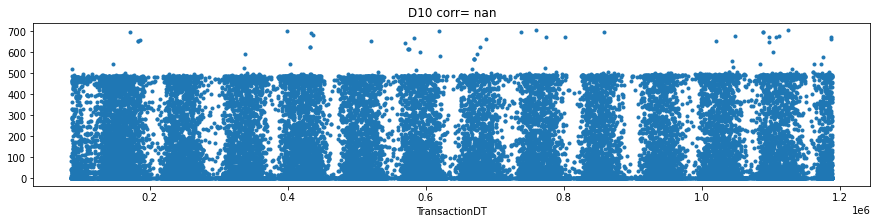

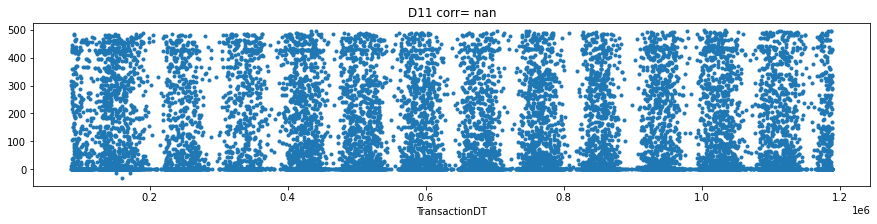

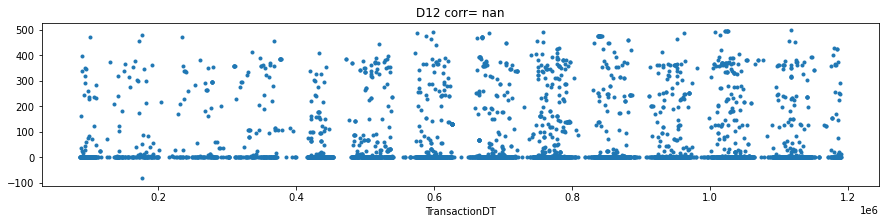

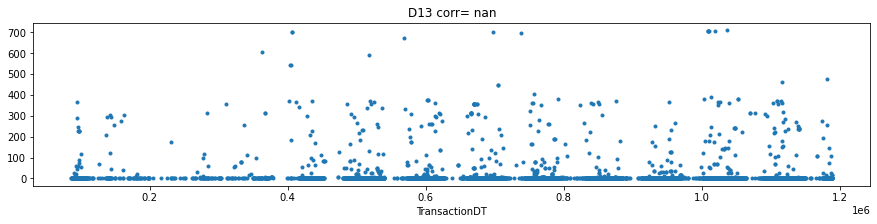

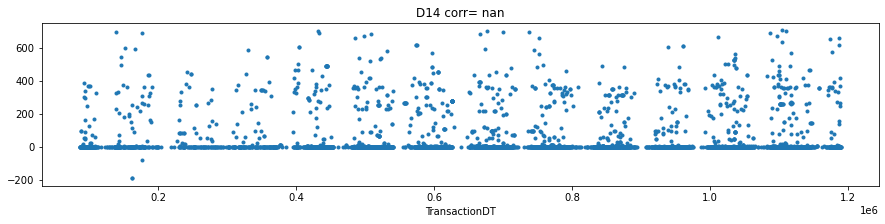

In [22]:
d_features = list(train_transaction.columns[19:33])

for i in d_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

In [23]:
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

D1         0
D2     26516
D3     25556
D4     23171
D5     32179
D6     45175
D7     47644
D8     41250
D9     41250
D10    12170
D11    34702
D12    45903
D13    46322
D14    45672
dtype: int64

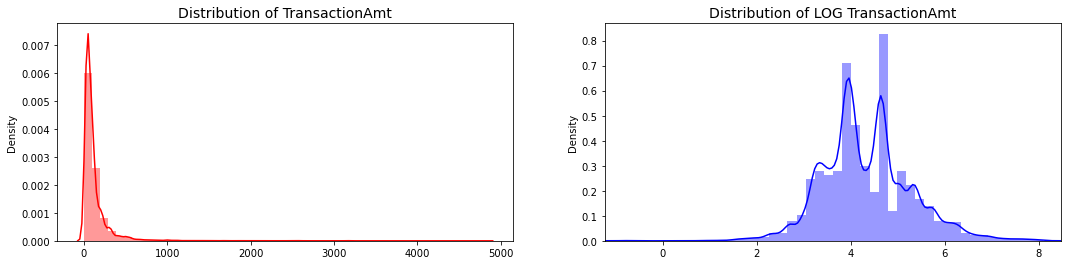

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

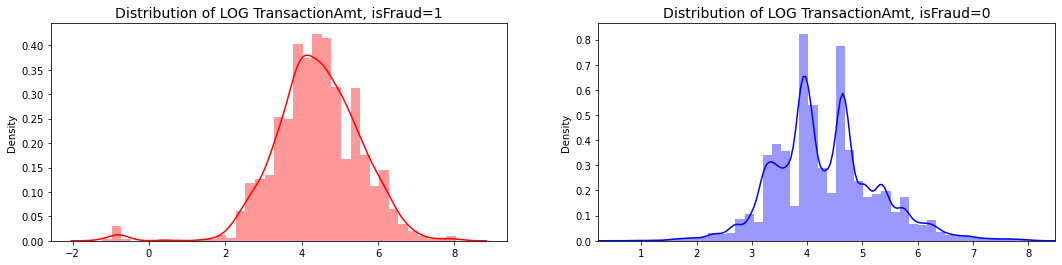

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

In [26]:
del time_val

In [27]:
train_transaction.describe()

isFraud  TransactionDT  TransactionAmt            C1  \
count  50000.000000   5.000000e+04    50000.000000  50000.000000   
mean       0.027140   6.377990e+05      128.123213     26.313600   
std        0.162493   3.229399e+05      213.075166    160.977331   
min        0.000000   8.640000e+04        0.292000      0.000000   
25%        0.000000   3.522868e+05       42.000000      1.000000   
50%        0.000000   6.537475e+05       68.500000      1.000000   
75%        0.000000   9.321258e+05      120.000000      3.000000   
max        1.000000   1.189336e+06     4829.950000   1892.000000   

                 C2            C3            C4            C5           C6  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.00000   
mean      33.171300      0.016240     11.668980      4.799620     16.24336   
std      214.143495      0.156002     94.124468     22.894044     95.49918   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%        1.000000      0.000000      0.000000      0.000000      1.00000   
50%        1.000000      0.000000      0.000000      0.000000      1.00000   
75%        3.000000      0.000000      0.000000      1.000000      2.00000   
max     2390.000000     16.000000   1166.000000    290.000000   1166.00000   

                 C7            C8            C9          C10           C11  \
count  50000.000000  50000.000000  50000.000000  50000.00000  50000.000000   
mean      10.650640     16.536120      3.766160     18.72006     20.302260   
std       91.773011    137.167204     14.680301    153.65613    127.642661   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        0.000000      0.000000      0.000000      0.00000      1.000000   
50%        0.000000      0.000000      1.000000      0.00000      1.000000   
75%        0.000000      1.000000      2.000000      1.00000      2.000000   
max     1167.000000   1742.000000    180.000000   1909.00000   1570.000000   

                C12           C13           C14            D1            D2  \
count  50000.000000  50000.000000  50000.000000  50000.000000  23484.000000   
mean      14.657400     40.656240     12.687540     81.400240    164.398229   
std      124.843307    158.909277     63.956223    139.516778    159.215459   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      1.000000      0.000000     28.000000   
50%        0.000000      2.000000      1.000000      0.000000    106.000000   
75%        0.000000     12.000000      2.000000    102.000000    278.000000   
max     1570.000000   1688.000000    784.000000    636.000000    636.000000   

                 D3            D4            D5           D6           D7  \
count  24444.000000  26829.000000  17821.000000  4825.000000  2356.000000   
mean      28.190476    134.461553     39.503844    70.176995    56.746604   
std       58.501079    170.299796     77.880678   138.558249   112.101622   
min        0.000000   -122.000000      0.000000   -83.000000     0.000000   
25%        1.000000      0.000000      1.000000     0.000000     0.000000   
50%        8.000000     32.000000     11.000000     0.000000     0.000000   
75%       28.000000    261.000000     31.000000    51.000000    35.000000   
max      616.000000    700.000000    656.000000   708.000000   673.000000   

                D8           D9           D10           D11          D12  \
count  8750.000000  8750.000000  37830.000000  15298.000000  4097.000000   
mean    177.833028     0.563085    120.110230    121.949536    56.910422   
std     247.611390     0.315374    164.260133    156.171221   118.768993   
min       0.000000     0.000000      0.000000    -33.000000   -83.000000   
25%       5.677083     0.208333      0.000000      0.000000     0.000000   
50%      66.875000     0.666666     23.000000     30.000000     0.000000   
75%     239.177078     0.791666    210.000000    232.00

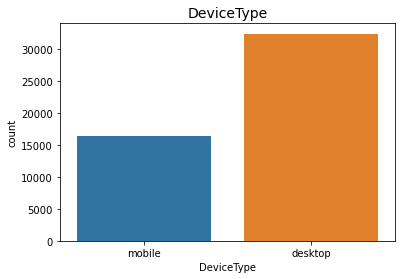

In [28]:
ax = sns.countplot(x="DeviceType", data=train_identity)
ax.set_title('DeviceType', fontsize=14)
plt.show()

In [29]:
print ("Unique Devices = ",train_identity['DeviceType'].nunique())
train_identity['DeviceType'].value_counts().head()

Unique Devices =  2


desktop    32337
mobile     16326
Name: DeviceType, dtype: int64

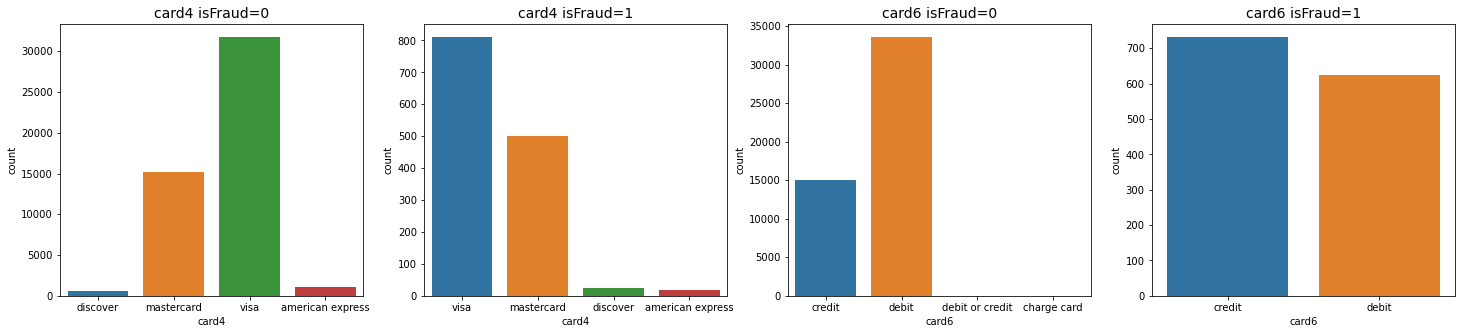

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

In [31]:
%%time
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype("uint8").copy()
print("Tain: ",train.shape)
del train_transaction, train_identity

Tain:  (50000, 390)
CPU times: total: 46.9 ms
Wall time: 43.7 ms


In [32]:
train

isFraud  TransactionDT  TransactionAmt       card4   card6  \
TransactionID                                                               
2987000              0          86400          68.500    discover  credit   
2987001              0          86401          29.000  mastercard  credit   
2987002              0          86469          59.000        visa   debit   
2987003              0          86499          50.000  mastercard   debit   
2987004              0          86506          50.000  mastercard  credit   
...                ...            ...             ...         ...     ...   
3036995              0        1189287         117.000        visa   debit   
3036996              0        1189295         200.000        visa  credit   
3036997              0        1189302         648.420        visa  credit   
3036998              0        1189311          21.221  mastercard   debit   
3036999              0        1189336         125.000    discover  credit   

                C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
TransactionID                                                               
2987000        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
2987001        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2987002        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987003        2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987004        1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3036995        4.0  3.0  0.0  0.0  3.0  4.0  0.0  0.0  3.0  0.0  4.0  0.0   
3036996        1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
3036997        1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
3036998        1.0  8.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  3.0  1.0  1.0   
3036999        1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

                C13  C14     D1     D2    D3    D4   D5    D6   D7     D8  \
TransactionID                                                               
2987000         1.0  1.0   14.0    NaN  13.0   NaN  NaN   NaN  NaN    NaN   
2987001         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
2987002         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
2987003        25.0  1.0  112.0  112.0   0.0  94.0  0.0   NaN  NaN    NaN   
2987004         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   
...             ...  ...    ...    ...   ...   ...  ...   ...  ...    ...   
3036995        76.0  2.0  409.0  409.0   2.0   NaN  NaN   NaN  NaN    NaN   
3036996         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   
3036997         1.0  1.0    0.0    NaN   NaN   0.0  NaN   NaN  NaN    NaN   
3036998         3.0  1.0   14.0   14.0   0.0  14.0  0.0  14.0  0.0  14.75   
3036999         1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN  NaN    NaN   

                 D9    D10    D11   D12   D13  D14    D15   M1   M2   M3   M5  \
TransactionID                                                                   
2987000         NaN   13.0   13.0   NaN   NaN  NaN    0.0    T    T    T    F   
2987001         NaN    0.0    NaN   NaN   NaN  NaN    0.0  NaN  NaN  NaN    T   
2987002         NaN    0.0  315.0   NaN   NaN  NaN  315.0    T    T    T    F   
2987003         NaN   84.0    NaN   NaN   NaN  NaN  111.0  NaN  NaN  NaN    T   
2987004         NaN    NaN    NaN   NaN   NaN  NaN    NaN  NaN  NaN  NaN  NaN   
...             ...    ...    ...   ...   ...  ...    ...  ...  ...  ...  ...   
3036995         NaN  386.0    NaN   NaN   NaN  NaN  386.0  NaN  NaN  NaN    T   
3036996         NaN    NaN    NaN   NaN   NaN  NaN    NaN  NaN  NaN  NaN  NaN   
3036997         NaN    0.0    NaN   NaN   NaN  NaN    0.0  NaN  NaN  NaN  NaN   
3036998        0.75    0.0    NaN  14.0  14.0  0.0   14.0  NaN  NaN  NaN  NaN   
3036999         NaN    NaN    NaN   N

In [33]:
y_train

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
          ..
3036995    0
3036996    0
3036997    0
3036998    0
3036999    0
Name: isFraud, Length: 50000, dtype: uint8

In [34]:
X_train = train.drop('isFraud', axis=1)

In [35]:
for f in X_train.columns:
    if X_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))

In [36]:
X_train

TransactionDT  TransactionAmt  card4  card6   C1   C2   C3  \
TransactionID                                                               
2987000                86400          68.500      1      1  1.0  1.0  0.0   
2987001                86401          29.000      2      1  1.0  1.0  0.0   
2987002                86469          59.000      4      2  1.0  1.0  0.0   
2987003                86499          50.000      2      2  2.0  5.0  0.0   
2987004                86506          50.000      2      1  1.0  1.0  0.0   
...                      ...             ...    ...    ...  ...  ...  ...   
3036995              1189287         117.000      4      2  4.0  3.0  0.0   
3036996              1189295         200.000      4      1  1.0  1.0  0.0   
3036997              1189302         648.420      4      1  1.0  1.0  0.0   
3036998              1189311          21.221      2      2  1.0  8.0  0.0   
3036999              1189336         125.000      1      1  1.0  1.0  0.0   

                C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1  \
TransactionID                                                                  
2987000        0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0   
2987001        0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0   
2987002        0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0   
2987003        0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0   
2987004        0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...   
3036995        0.0  3.0  4.0  0.0  0.0  3.0  0.0  4.0  0.0  76.0  2.0  409.0   
3036996        1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0   
3036997        0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0   
3036998        1.0  0.0  1.0  1.0  1.0  0.0  3.0  1.0  1.0   3.0  1.0   14.0   
3036999        1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0   

                  D2    D3    D4   D5    D6   D7     D8    D9    D10    D11  \
TransactionID                                                                 
2987000          NaN  13.0   NaN  NaN   NaN  NaN    NaN   NaN   13.0   13.0   
2987001          NaN   NaN   0.0  NaN   NaN  NaN    NaN   NaN    0.0    NaN   
2987002          NaN   NaN   0.0  NaN   NaN  NaN    NaN   NaN    0.0  315.0   
2987003        112.0   0.0  94.0  0.0   NaN  NaN    NaN   NaN   84.0    NaN   
2987004          NaN   NaN   NaN  NaN   NaN  NaN    NaN   NaN    NaN    NaN   
...              ...   ...   ...  ...   ...  ...    ...   ...    ...    ...   
3036995        409.0   2.0   NaN  NaN   NaN  NaN    NaN   NaN  386.0    NaN   
3036996          NaN   NaN   NaN  NaN   NaN  NaN    NaN   NaN    NaN    NaN   
3036997          NaN   NaN   0.0  NaN   NaN  NaN    NaN   NaN    0.0    NaN   
3036998         14.0   0.0  14.0  0.0  14.0  0.0  14.75  0.75    0.0    NaN   
3036999          NaN   NaN   NaN  NaN   NaN  NaN    NaN   NaN    NaN    NaN   

                D12   D13  D14    D15  M1  M2  M3  M5  M6  M7  M8  M9   V1  \
TransactionID                                                                
2987000         NaN   NaN  NaN    0.0   0   1   1   0   1   2   2   2  1.0   
2987001         NaN   NaN  NaN    0.0   1   2   2   1   1   2   2   2  NaN   
2987002         NaN   NaN  NaN  315.0   0   1   1   0   0   0   0   0  1.0   
2987003         NaN   NaN  NaN  111.0   1   2   2   1   0   2   2   2  NaN   
2987004         NaN   NaN  NaN    NaN   1   2   2   2   2   2   2   2  NaN   
...             ...   ...  ...    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...   
3036995         NaN   NaN  NaN  386.0   1   2   2   1   1   2   2   2  NaN   
3036996         NaN   NaN  NaN    NaN   1   2   2   2   2   2   2   2  NaN   
3036997         NaN   NaN  NaN    0.0   1   2   2   2   0   2   2   2  NaN   
3036998        14.0  14.0  0.0   14.0   1   2   2   2   2   2   2   2  NaN   
3036999 

In [37]:
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [38]:
X_train = reduce_mem_usage2(X_train)

Memory usage of dataframe is 146.35 MB
Memory usage after optimization is: 39.92 MB
Decreased by 72.7%


In [39]:
drop_col = ['TransactionDT']
X_train.drop(drop_col,axis=1, inplace=True)
X_train.head()

TransactionAmt  card4  card6   C1   C2   C3   C4   C5   C6  \
TransactionID                                                               
2987000                  68.5      1      1  1.0  1.0  0.0  0.0  0.0  1.0   
2987001                  29.0      2      1  1.0  1.0  0.0  0.0  0.0  1.0   
2987002                  59.0      4      2  1.0  1.0  0.0  0.0  0.0  1.0   
2987003                  50.0      2      2  2.0  5.0  0.0  0.0  0.0  4.0   
2987004                  50.0      2      1  1.0  1.0  0.0  0.0  0.0  1.0   

                C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3  \
TransactionID                                                                
2987000        0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   
2987001        0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
2987002        0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
2987003        0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   
2987004        0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   

                 D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15  \
TransactionID                                                                 
2987000         NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0   
2987001         0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0   
2987002         0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0   
2987003        94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN  111.0   
2987004         NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN    NaN   

               M1  M2  M3  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5   V6  \
TransactionID                                                                 
2987000         0   1   1   0   1   2   2   2  1.0  1.0  1.0  1.0  1.0  1.0   
2987001         1   2   2   1   1   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN   
2987002         0   1   1   0   0   0   0   0  1.0  1.0  1.0  1.0  1.0  1.0   
2987003         1   2   2   1   0   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN   
2987004         1   2   2   2   2   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN   

                V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
TransactionID                                                               
2987000        1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987001        NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2987002        1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987003        NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  \
TransactionID                                                               
2987000        1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987001        1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987002        1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987003        1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  \
TransactionID                                                               
2987000        0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2987001        0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0   
2987002        0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0   
2987003        0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  \
TransactionID                                                               
2987000        NaN  NaN  NaN  NaN  NaN  NaN  N

In [40]:
X_train.fillna(-1,inplace=True)
X_train.head()

TransactionAmt  card4  card6   C1   C2   C3   C4   C5   C6  \
TransactionID                                                               
2987000                  68.5      1      1  1.0  1.0  0.0  0.0  0.0  1.0   
2987001                  29.0      2      1  1.0  1.0  0.0  0.0  0.0  1.0   
2987002                  59.0      4      2  1.0  1.0  0.0  0.0  0.0  1.0   
2987003                  50.0      2      2  2.0  5.0  0.0  0.0  0.0  4.0   
2987004                  50.0      2      1  1.0  1.0  0.0  0.0  0.0  1.0   

                C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3  \
TransactionID                                                                
2987000        0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0   -1.0  13.0   
2987001        0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0   -1.0  -1.0   
2987002        0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0   -1.0  -1.0   
2987003        0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   
2987004        0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0   -1.0  -1.0   

                 D4   D5   D6   D7   D8   D9   D10    D11  D12  D13  D14  \
TransactionID                                                              
2987000        -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  13.0   13.0 -1.0 -1.0 -1.0   
2987001         0.0 -1.0 -1.0 -1.0 -1.0 -1.0   0.0   -1.0 -1.0 -1.0 -1.0   
2987002         0.0 -1.0 -1.0 -1.0 -1.0 -1.0   0.0  315.0 -1.0 -1.0 -1.0   
2987003        94.0  0.0 -1.0 -1.0 -1.0 -1.0  84.0   -1.0 -1.0 -1.0 -1.0   
2987004        -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  -1.0   -1.0 -1.0 -1.0 -1.0   

                 D15  M1  M2  M3  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5  \
TransactionID                                                                   
2987000          0.0   0   1   1   0   1   2   2   2  1.0  1.0  1.0  1.0  1.0   
2987001          0.0   1   2   2   1   1   2   2   2 -1.0 -1.0 -1.0 -1.0 -1.0   
2987002        315.0   0   1   1   0   0   0   0   0  1.0  1.0  1.0  1.0  1.0   
2987003        111.0   1   2   2   1   0   2   2   2 -1.0 -1.0 -1.0 -1.0 -1.0   
2987004         -1.0   1   2   2   2   2   2   2   2 -1.0 -1.0 -1.0 -1.0 -1.0   

                V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
TransactionID                                                               
2987000        1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987001       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  0.0  0.0  1.0  0.0  0.0  0.0   
2987002        1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987003       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987004       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

               V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
TransactionID                                                               
2987000        0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987001        0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987002        0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987003        0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2987004       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

               V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  \
TransactionID                                                               
2987000        0.0  0.0  0.0  0.0  0.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
2987001        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
2987002        0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
2987003        0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
2987004       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

               V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  \
TransactionID                                                               
2987000       -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0

In [41]:
#SMOTE
sm = SMOTE(random_state = 42, k_neighbors = 5)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [42]:
y_train_over

0        0
1        0
2        0
3        0
4        0
        ..
97281    1
97282    1
97283    1
97284    1
97285    1
Name: isFraud, Length: 97286, dtype: uint8

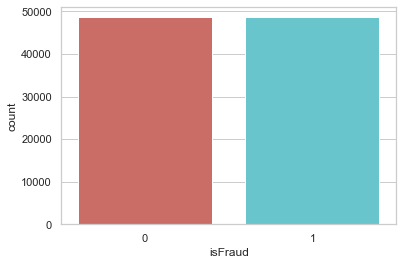

In [43]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

class_data = pd.DataFrame(y_train_over)

sns.countplot(x='isFraud', data = class_data, palette='hls')
plt.show()

In [46]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers,metrics
import tensorflow
from keras.wrappers.scikit_learn import KerasClassifier

dr = 0.4
neurons = 512

with tensorflow.device('/gpu:0'):
    model = keras.Sequential([ 
        layers.BatchNormalization(input_shape=[388]),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='swish'),
        layers.Dropout(dr),
        layers.BatchNormalization(),
    #     layers.Dense(128, activation='swish'), 
    #     layers.Dropout(0.5),
    #     layers.BatchNormalization(),
    #     layers.Dense(128, activation='swish'), 
    #     layers.Dropout(0.5),
    #     layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    early_stopping = keras.callbacks.EarlyStopping(
        monitor = 'val_f1',
        mode = 'max',
        patience=20,
        min_delta=0.0001,
        
        restore_best_weights=True,
    )
    model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss=keras.losses.BinaryCrossentropy(label_smoothing=1e-3),
                    metrics=[f1],
                    

                )
    history = model.fit(        
        X_train_over, y_train_over,
        batch_size=256,
        epochs=638,
        callbacks=[early_stopping],
        verbose=1, 
    )

Epoch 1/638
381/381 [==============================] - 26s 62ms/step - loss: 0.6098 - f1: 0.6876
Epoch 2/638
381/381 [==============================] - 24s 62ms/step - loss: 0.4537 - f1: 0.7925
Epoch 3/638
381/381 [==============================] - 24s 63ms/step - loss: 0.4023 - f1: 0.8186
Epoch 4/638
381/381 [==============================] - 24s 63ms/step - loss: 0.3741 - f1: 0.8324
Epoch 5/638
381/381 [==============================] - 26s 68ms/step - loss: 0.3552 - f1: 0.8417
Epoch 6/638
381/381 [==============================] - 24s 63ms/step - loss: 0.3378 - f1: 0.8518
Epoch 7/638
381/381 [==============================] - 24s 62ms/step - loss: 0.3256 - f1: 0.8576
Epoch 8/638
381/381 [==============================] - 24s 63ms/step - loss: 0.3165 - f1: 0.8628
Epoch 9/638
381/381 [==============================] - 24s 63ms/step - loss: 0.3042 - f1: 0.8694
Epoch 10/638
381/381 [==============================] - 24s 64ms/step - loss: 0.2969 - f1: 0.8718
Epoch 11/638
381/381 [=======